# Ratings Prediction Notebook

In [28]:
# load all necessary libraries 
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB  
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import mean_absolute_error, confusion_matrix
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords 
from collections import Counter
from joblib import dump, load
import matplotlib.pyplot as plt 
import nltk 
import pandas as pd
import numpy as np
import collections
import regex 



In [4]:
ratings = pd.read_csv('../data/ratings.csv')
ratings.head()

,TEXT,RATING
0,The shirt was more of a smock. I expected a so...,1
1,The shirt was more of a smock. I expected a so...,1
2,The shirt was more of a smock. I expected a so...,1
3,Just received my order today. When I opened th...,1
4,"First of all, the button hole on this belt nev...",1


In [3]:
ratings.describe()

,RATING
count,10000.000000
mean,3.000000
std,1.414284
min,1.000000
25%,2.000000
50%,3.000000
75%,4.000000
max,5.000000


## Labels Analysis
We can see that the labels from this dataset are discrete numbers from 1 to 5, thus this is a classification problem, more specifically, a sentiment analysis problem. From counting the labels we can see that the dataset is perfectly balanced that is great for training since the model won't be biased towards a specific class. 

In [5]:
labels = np.array(ratings['RATING']) 
ocurrences = collections.Counter(labels)
ocurrences

Counter({1: 2000, 2: 2000, 3: 2000, 5: 2000, 4: 2000})

## Variables analysis
To analyse the words we need a tokenizer that can separate each sentence into a useful list of words. A tokenizer can be of many types, here we try 3 different ones. But in the future a better, more specialized tokenizer is needed 


In [7]:
# The first tokenizer is a simple python split, let's try it with an arbitrary sentence 
# 
# An obvious problem with this method is the inclusion of the '.' character in some words, 
# this can increase a lot the dictionary size of the dataset

reviews = np.array(ratings['TEXT']) 
sample_review = reviews[42]
sample_review

"Bloody awful. I got to wash these twice on gentle cycle and already they're full of holes. So much for style and comfort...I got to wear these twice and they look like I was standing too close to a fire already. Swiss cheese pants!"

In [6]:
sample_review = reviews[42]
sample_review = np.array(sample_review.split()) 
sample_review

array(['Bloody', 'awful.', 'I', 'got', 'to', 'wash', 'these', 'twice',
       'on', 'gentle', 'cycle', 'and', 'already', "they're", 'full', 'of',
       'holes.', 'So', 'much', 'for', 'style', 'and', 'comfort...I',
       'got', 'to', 'wear', 'these', 'twice', 'and', 'they', 'look',
       'like', 'I', 'was', 'standing', 'too', 'close', 'to', 'a', 'fire',
       'already.', 'Swiss', 'cheese', 'pants!'], dtype='<U11')

In [7]:
# Lets try a more complex method , now the useess puntuation marks are gone
# although we now have abbreviation issues such as wasn't 
sample_review = reviews[42]
sample_review = np.array(regex.split(r'[-\s.,;!?]+', reviews[42]))
sample_review

array(['Bloody', 'awful', 'I', 'got', 'to', 'wash', 'these', 'twice',
       'on', 'gentle', 'cycle', 'and', 'already', "they're", 'full', 'of',
       'holes', 'So', 'much', 'for', 'style', 'and', 'comfort', 'I',
       'got', 'to', 'wear', 'these', 'twice', 'and', 'they', 'look',
       'like', 'I', 'was', 'standing', 'too', 'close', 'to', 'a', 'fire',
       'already', 'Swiss', 'cheese', 'pants', ''], dtype='<U8')

In [8]:
# An ever more complete tokenizer is the one included in the NLTK library, although this 
# creates more tokens because it keeps dots at the end it might be useful for the training 
sample_review = reviews[42]
tokenizer = TreebankWordTokenizer()
sample_review = np.array(tokenizer.tokenize(sample_review))
sample_review

array(['Bloody', 'awful.', 'I', 'got', 'to', 'wash', 'these', 'twice',
       'on', 'gentle', 'cycle', 'and', 'already', 'they', "'re", 'full',
       'of', 'holes.', 'So', 'much', 'for', 'style', 'and', 'comfort',
       '...', 'I', 'got', 'to', 'wear', 'these', 'twice', 'and', 'they',
       'look', 'like', 'I', 'was', 'standing', 'too', 'close', 'to', 'a',
       'fire', 'already.', 'Swiss', 'cheese', 'pants', '!'], dtype='<U8')

Other text preprocessing methods such as case folding and removing stop words might help the model generalize and reduce the dimensions of the input, thus avoiding "The curse of dimensionality". The stop words are also downloaded from the NLTK library 

In [8]:
# Now we will apply case folding to reduce the vocabulary 
sample_review = np.array([token.lower() for token in sample_review])
sample_review

array(['bloody', 'awful.', 'i', 'got', 'to', 'wash', 'these', 'twice',
       'on', 'gentle', 'cycle', 'and', 'already', 'they', "'re", 'full',
       'of', 'holes.', 'so', 'much', 'for', 'style', 'and', 'comfort',
       '...', 'i', 'got', 'to', 'wear', 'these', 'twice', 'and', 'they',
       'look', 'like', 'i', 'was', 'standing', 'too', 'close', 'to', 'a',
       'fire', 'already.', 'swiss', 'cheese', 'pants', '!'], dtype='<U8')

In [12]:
# Now for an extra preprocessign we want to remove stop words 
nltk.download('stopwords')
stop_words = stopwords.words('english')
sample_review = np.array([token for token in sample_review if token not in stop_words]) 
sample_review

[nltk_data] Downloading package stopwords to /home/pol/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


array(['Bloody', 'awful.', 'I', 'got', 'wash', 'twice', 'gentle', 'cycle',
       'already', "'re", 'full', 'holes.', 'So', 'much', 'style',
       'comfort', '...', 'I', 'got', 'wear', 'twice', 'look', 'like', 'I',
       'standing', 'close', 'fire', 'already.', 'Swiss', 'cheese',
       'pants', '!'], dtype='<U8')

In [10]:
encoder = OneHotEncoder()
encodings = encoder.fit_transform(sample_review.reshape(1, -1)) 
encodings.toarray()

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

**Before going any further we will perform a split train/test split to remove  my personal bias on the dataset**

In [10]:
# I want to be sure that the datasets stay balanced to help the model into generalizing 
# now we will only work with the training set and we will never look the eval set 
# again 
X_train, X_eval, y_train, y_eval = train_test_split(reviews, labels, test_size=0.2, random_state=42)


In [34]:
# now lets analyse the data further by calculating some global characteristics 
# of each sentence, such as the avg length. This is just an estimate becasuse the 
# sentence lenght dependes directly on the tokenizer we are using
list_of_words = np.array(list(map(sentence_preprocessing, X_train)))
reviews_lenghts = np.array([len(review) for review in list_of_words]) 
print('mean:', reviews_lenghts.mean())
print('std:', reviews_lenghts.std())
print('min',reviews_lenghts.min())
print('max', reviews_lenghts.max())

mean: 26.283875
std: 19.62603602321098
min 1
max 219


There are some sentences with a extremely low nubmer of words in it (i.e. 1 token). We should explore this extreme cases and evaluate if their are outliers that must be removed from the training dataset

In [35]:
print('Review:', X_train[reviews_lenghts.argmin()]) 
print('Label:', y_train[reviews_lenghts.argmin()])

Review: I am 5'8\
Label: 1


In [9]:
def sentence_preprocessing(sentence):
    """
    Given a sentece, it returns a list 
    of tokens that have been preprocessed and filtered 
    using multiple strategies. 
    """
    # First we create the list of tokens 
    tokenizer = TreebankWordTokenizer()
    sentence = tokenizer.tokenize(sentence)
    # We then apply case folding 
    sentence = [token.lower() for token in sentence]
    return [token for token in sentence if token not in stop_words] 


def create_bow(data):
    """
    Given a list of sentences it creates and returns a 
    dataframe with prepared for training 
    """

    # Now lets create a bag of words using a simple split 
    bow = []
    for sentence in data:
        bow.append(Counter(sentence_preprocessing(sentence)))
    
    # Create a dataframe with all the records from the bag of words 
    df = pd.DataFrame.from_records(bow)
    df = df.fillna(0).astype(int)
    return df 

The Following dataframe represents the training dataset with the vocabulary size, the training set has a lenght of **8000** (80 percent of the original dataset). And a vocabulary of **7964** words 

In [13]:
df = create_bow(X_train)
print('Shape:', df.shape)

Shape: (8000, 7954)


In [39]:
df

,need,bra,minimizes,!,more.,although,back,cup,size,",",...,one\nsmall,join,51,wrinkly.,lighting,i.,haute,couture,teens,woman.\nretuned
0,2,2,1,1,1,1,1,1,1,2,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2,0,2,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7996,0,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7997,0,2,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7998,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we would like to create an analysis on how the **TF** (term frequences) are in the dataset, for this we will use a `collections.Counter` to calculate the most used words in the entire corpus no just on a single review

In [14]:
# Study term frequencies 
bow = []
for sentence in X_train:
    bow.append(Counter(sentence_preprocessing(sentence)))

all_counters = collections.Counter()
for counter in bow:
    all_counters = all_counters + counter 

In [15]:
all_counters

Counter({'need': 436,
         'bra': 4103,
         'minimizes': 19,
         '!': 3977,
         'more.': 53,
         'although': 131,
         'back': 1053,
         'cup': 649,
         'size': 2143,
         ',': 11355,
         'find': 461,
         'straps': 923,
         'could': 694,
         'go': 363,
         'little': 780,
         'tighter': 53,
         'even': 659,
         'though': 310,
         'tightest': 26,
         "'s": 1454,
         'tight': 388,
         'would': 1745,
         'prefer': 96,
         'still': 518,
         'works': 147,
         '.': 5362,
         'shoulder': 79,
         'roll': 70,
         'time': 659,
         'making': 92,
         'uncomfortable': 300,
         'bali': 518,
         '38dd.': 7,
         'favorite': 144,
         'ever': 203,
         'ordered': 900,
         '3': 289,
         'site': 33,
         'received': 197,
         '(': 1069,
         'marked': 30,
         'item': 147,
         '#': 59,
         '3383': 4,
  

After combining all counters of each review we can see the 10 most common tokens in the dataset. Unfortunately the most common one is the *','* symbol with a very big frequency of 11355, bigger than the number of instances in the entire dataset. That means that the comma does not provide any useful information at all, even if we suppose that is a *useful* token grammatically speaking, it is extremely repeated to the point that it has lost its purpose. And we have not taken into account ','s that are a postfix of a word. A lot of the following words are similar such as the dot. And as we will see later on the exclamation mark is biased. All this points to one thing, we must improve the tokenizer. 

In [18]:
all_counters.most_common(10)

[(',', 11355),
 ('.', 5362),
 ('bra', 4103),
 ('!', 3977),
 ("n't", 2698),
 ('size', 2143),
 ('like', 2025),
 ('would', 1745),
 ('fit', 1724),
 ('wear', 1514)]

## Model Training 
As for the training, the model has a little variance towards the training set as it is too espect. Also, after many test we can see that the accuracy of the training set is between 0.8 and 0.9 and the accuracy on the test set is between 0.7 and 0.8. 

In [19]:
classifier = MultinomialNB()
classifier = classifier.fit(df, y_train)

In [20]:
y_pred = classifier.predict(df)
accuracy_score(y_train,y_pred)

0.86175

**Important, the new dataset has aproximately 300 new tokens that were not in the training set, that might afect the perfomance on the test set**

In [21]:
# We need to make sure that columns from the training dataframe correspond the the exact same 
# cols in the test dataset 
df_test = create_bow(X_eval)
print('Shape:', df_test.shape)
all_bows = df.append(df_test)
print('New bigger shape:', all_bows.shape)
df_test = all_bows.iloc[len(df):][df.columns] # select only the test samples and the training cols 
print('New df with filtered cols shape:', df_test.shape)

Shape: (2000, 5378)
New bigger shape: (10000, 8295)
New df with filtered cols shape: (2000, 7954)


In [22]:
df_test = df_test.fillna(0).astype(int)
y_pred = classifier.predict(df_test)
accuracy_score(y_eval,y_pred)

0.7645

Metrics show that recall and precision have the same value as accuracy, if we had used lemmatization or stemming precision would probably be lower. A thing to take into account is that the mean absolute error is very small, this metric as well as some manual testing can tell us that even though the model does not calculate the exact rating always, it is generally off by 1 star (rating measure)

In [25]:
print('Recall score:', recall_score(y_eval, y_pred, average='micro')) 
print('Precision score:', precision_score(y_eval, y_pred, average='micro'))
print('Mean absolute error:', mean_absolute_error(y_eval, y_pred))

Recall score: 0.7645
Precision score: 0.7645
Mean absolute error: 0.3675


With the confusion matrix it is easy to rasure the previous statement, where labels are often off by one star. We can see that because most predictions are correct and the incorrect ones are adjecent to the predicted ones. 

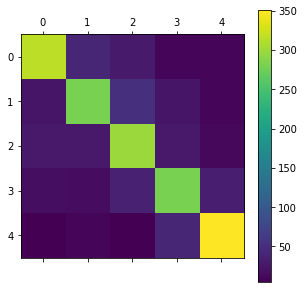

In [33]:
mat = confusion_matrix(y_eval, y_pred)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
cax = ax.matshow(mat)
fig.colorbar(cax)
plt.show()


## Classifier saving

In [47]:
dump(classifier, '../data/classifier.joblib')

['../data/classifier.joblib']

In [25]:
classifier = load('../data/classifier.joblib')

In [26]:
y_pred = classifier.predict(df_test)
accuracy_score(y_eval,y_pred)

0.779

## Extra
For the classifier to be able to predict new unseed sentences we need to ensure that the preprocessed data has the same number of columnns in the same order than in the trainin set, to be able to do that later on (in api calls) we need to save a **sample dataframe** with all necessary information

In [49]:
df_test.iloc[:2]

,need,bra,minimizes,!,more.,although,back,cup,size,",",...,one\nsmall,join,51,wrinkly.,lighting,i.,haute,couture,teens,woman.\nretuned
0,0,0,0,1,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
df_test.iloc[:2].to_csv('../data/dataframe_sample.csv', index=False)